In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/Software_Carpentry_Final_Project'

/content/drive/My Drive/Colab Notebooks/Software_Carpentry_Final_Project


In [ ]:
import matplotlib.pyplot as plt
import csv
import random
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


class TrainDataset():
    '''
    Training Dataset class for pytorch dataloader
    '''
    def __init__(self, rootpath, transforms=None):
        '''
        Initiate class variables

        Parameters
        ----------
        rootpath : str
            The directory of the training dataset
        transforms : <class 'torchvision.transforms.transforms.Compose'>
            Transforms that will be applied to the images

        Returns
        -------
        None.

        '''
        self.rootpath = rootpath
        self.images = []  # images
        self.labels = []  # corresponding labels
        self.transforms = transforms
        for c in range(0, 43):
            # subdirectory for class
            prefix = self.rootpath + '/' + format(c, '05d') + '/'
            # annotations file
            gtFile = open(prefix + 'GT-' + format(c, '05d') + '.csv')
            # csv parser for annotations file
            gtReader = csv.reader(gtFile, delimiter=';')
            # skip header
            next(gtReader)
            # loop over all images in current annotations file
            for row in gtReader:
                image = Image.open(prefix + row[0], 'r')
                image_arr = np.array(image)
                image.close()
                image = Image.fromarray(image_arr)
                # the 1th column is the filename
                self.images.append(image)
                # the 8th column is the label
                self.labels.append(int(row[7]))
            gtFile.close()

    def __len__(self):
        '''
        Length of the class or dataset

        Returns
        -------
        int
            Length of the dataset

        '''
        return len(self.images)

    def __getitem__(self, idx):
        '''
        Used for list indexing

        Parameters
        ----------
        idx : int
            indexs for the list

        Returns
        -------
        image : PIL file
            Returns PIL file for later transformation
        label : torch.tensor
            Returns torch.tensor of the labels

        '''
        label = torch.tensor((self.labels[idx]))
        image = self.transforms(self.images[idx])
        return image, label

    def img_transform(image):
        '''
        Transforms applied to the image

        Parameters
        ----------
        image : PIL Image
            A list of PIL images

        Returns
        -------
        image : torch.Tensor
            transforms the images with the transform class

        '''
        image = self.transforms(image)
        return image

In [ ]:
class TestDataset():
    '''
    Testing Dataset class for pytorch dataloader
    '''
    def __init__(self, rootpath, filename, transforms=None):
        '''
        Initiate class variables

        Parameters
        ----------
        rootpath : str
            The directory of the training dataset
        filename : str
            Excel file name that contains the ground truth of testing dataset
        transforms : <class 'torchvision.transforms.transforms.Compose'>
            Transforms that will be applied to the images

        Returns
        -------
        None.

        '''
        self.rootpath = rootpath
        self.images = []  # images
        self.labels = []  # corresponding labels
        self.transforms = transforms
        prefix = self.rootpath + '/'
        with open(filename) as f:
            gtReader = csv.reader(f, delimiter=';')
            next(gtReader)
            for row in gtReader:
                image = Image.open(prefix + row[0], 'r')
                image_arr = np.array(image)
                image.close()
                image = Image.fromarray(image_arr)
                self.images.append(image)  # the 1th column is the filename
                self.labels.append(int(row[7]))  # the 8th column is the label

    def __len__(self):
        '''
        Length of the class or dataset

        Returns
        -------
        int
            Length of the dataset

        '''
        return len(self.images)

    def __getitem__(self, idx):
        '''
        Used for list indexing

        Parameters
        ----------
        idx : TYPE
            DESCRIPTION.

        Returns
        -------
        image : PIL file
            Returns PIL file for later transformation
        label : torch.tensor
            Returns torch.tensor of the labels

        '''
        label = torch.tensor((self.labels[idx]))
        image = self.transforms(self.images[idx])
        return image, label

    def img_transform(image):
        '''
        Transforms applied to the image

        Parameters
        ----------
        image : PIL Image
            A list of PIL images

        Returns
        -------
        image : torch.Tensor
            transforms the images with the transform class

        '''
        image = self.transforms(image)
        return image

In [ ]:
train_loader = torch.load('./GTSRB/train_dataloader_32_random_colab.pth')

In [ ]:
val_loader = torch.load('./GTSRB/val_dataloader_32_random_colab.pth')

In [ ]:
test_loader = torch.load('./GTSRB/test_dataloader_32_colab.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([16])


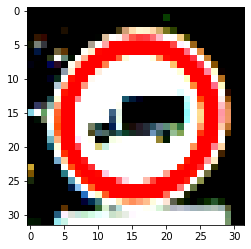

In [ ]:
x, y = next(iter(train_loader))
print(y)
plt.imshow(x.numpy().squeeze(axis=0).transpose(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([11])


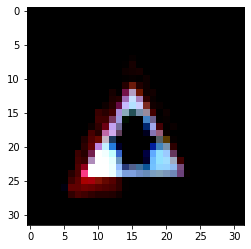

In [ ]:
x, y = next(iter(val_loader))
print(y)
plt.imshow(x.numpy().squeeze(axis=0).transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([16])


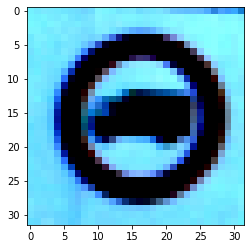

In [ ]:
x, y = next(iter(test_loader))
print(y)
plt.imshow(x.numpy().squeeze(axis=0).transpose(1, 2, 0))

In [ ]:
class Net(nn.Module):
    '''
    Neural network models used for this challenge.
    '''
    def __init__(self):
        '''
        Initiate class variables

        Returns
        -------
        None.

        '''
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(250)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(250*2*2, 350)
        self.fc2 = nn.Linear(350, 43)

    def forward(self, x):
        '''
        Forward function from input to output

        Parameters
        ----------
        x : torch.tensor
            torch.tensors or the images in the dataset

        Returns
        -------
        TYPE torch.tensor
            predicted labels

        '''
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = self.bn1(x)
        x = self.drop(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.bn2(x)
        x = self.drop(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = self.bn3(x)
        x = self.drop(x)
        x = x.view(-1, 250*2*2)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
gpu_boole = torch.cuda.is_available()

In [ ]:
gpu_boole

True

In [ ]:
net = Net()
if gpu_boole:
    net = net.cuda()

In [ ]:
# Using Adam as the optimizer and CrossEntropyLoss for loss metric
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_metric = torch.nn.CrossEntropyLoss()

In [ ]:
def calc_accuracy(true_y, pred_y):
    '''
    Calculate the accuracy between the grouth truth and prediced label

    Parameters
    ----------
    true_y : torch.tensor
        Grouth truth label for the image
    pred_y : torch.tensor
        Predicted label for the image

    Returns
    -------
    accuracy : float
        Accuracy of the predicted label compared with the ground truth

    '''
    true_prediction_num = 0
    for i, py in enumerate(pred_y):
        idx = torch.argmax(py)
        if idx == true_y[i]:
            true_prediction_num += 1
    accuracy = true_prediction_num / len(pred_y)
    return accuracy

In [ ]:
def eval(net, loader, verbose=1):
    '''
    Evaluation of the model with loss and accuracy returned

    Parameters
    ----------
    net : Model class
        Class of the model or neural network
    loader : torch.utils.data.dataloader.DataLoader
        The pytorch dataloader
    verbose :
        The default is 1.

    Returns
    -------
    float
        The accuracy of the model to predict the loader
    loss_avg : float
        The average loss for predicting the loader

    '''
    loss_sum = []
    acc = []
    for x, labels in loader:
        if gpu_boole:
            x, labels = x.cuda(), labels.cuda()
        with torch.no_grad():
            outputs = net(x)
    predicted = outputs.data.round()
    loss = loss_metric(outputs, labels)
    loss_sum.append(loss.cpu().data.numpy().item())
    loss_avg = np.mean(loss_sum)
    acc.append(calc_accuracy(labels, predicted))
    if verbose:
        print('Accuracy: %f %%' % (100.0 * np.mean(acc)))
        print('Loss: %f' % loss_avg)
    return 100 * np.mean(acc), loss_avg


In [ ]:
# re-initializing network weights:
def weights_init(m):
    '''
    Weight initiation of the model

    Parameters
    ----------
    m : Model class
        Class of the model or neural network

    Returns
    -------
    None.

    '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
net.apply(weights_init)

Net(
  (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(150, 250, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1000, out_features=350, bias=True)
  (fc2): Linear(in_features=350, out_features=43, bias=True)
)

Starting Training
Epoch 1 :
The accuracy and loss for training, validation, and testing respectively are
Accuracy: 80.337143 %
Loss: 0.595405
Accuracy: 79.401283 %
Loss: 0.631794
Elapsed time for epoch: 292.2396376132965 s
ETA of completion: 725.728433406353 minutes

Epoch 2 :
The accuracy and loss for training, validation, and testing respectively are
Accuracy: 90.334286 %
Loss: 0.292574
Accuracy: 89.237349 %
Loss: 0.344825
Elapsed time for epoch: 293.22661900520325 s
ETA of completion: 723.2923268795014 minutes

Epoch 3 :
The accuracy and loss for training, validation, and testing respectively are
Accuracy: 93.714286 %
Loss: 0.202350
Accuracy: 93.513899 %
Loss: 0.230471
Elapsed time for epoch: 292.38768696784973 s
ETA of completion: 716.3498330712318 minutes

Epoch 4 :
The accuracy and loss for training, validation, and testing respectively are
Accuracy: 94.405714 %
Loss: 0.177165
Accuracy: 94.084105 %
Loss: 0.219512
Elapsed time for epoch: 292.0464200973511 s
ETA of completion: 710.

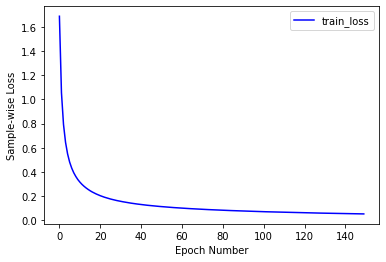

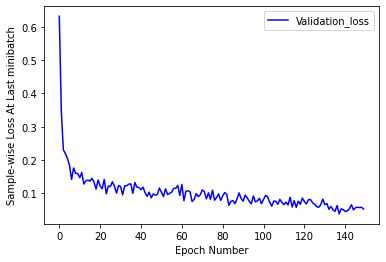

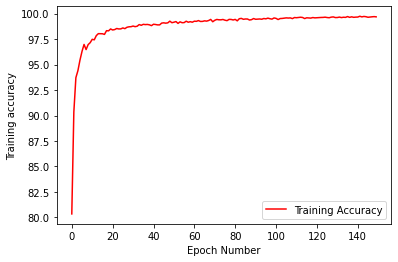

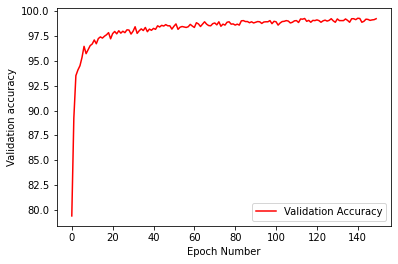

In [ ]:
import time
# number of epochs to train for:
epochs = 150  # This number can be changed
# defining batch train loss recording arrays for later visualization/plotting:
loss_batch_store = []
loss_batch = []
acc_test = []
acc_val = []
acc_train = []
loss_val = []
loss_train = []
print("Starting Training")
# training loop:
for epoch in range(epochs):
    time1 = time.time()  # timekeeping
    for i, (x, y) in enumerate(train_loader):
        if gpu_boole:
            x = x.cuda()
            y = y.cuda()
    # Loss calculation and gradient update:
    if i > 0 or epoch > 0:
        optimizer.zero_grad()
    outputs = net(x)
    loss = loss_metric(outputs, y.long())
    loss.backward()
    # Create a batch store for all losses
    if i > 0 or epoch > 0:
        loss_batch_store.append(loss.cpu().data.numpy().item())
    # Performing update:
    optimizer.step()
    loss_batch.append(np.mean(loss_batch_store))
    print("Epoch", epoch+1, ':')
    print("The accuracy and loss for training, validation, "
          "and testing respectively are")
    train_perc, train_loss = eval(net, train_loader, gpu_boole)
    val_perc, val_loss = eval(net, val_loader, gpu_boole)
    # test_perc, test_loss, test_predicted = eval(net, test_loader, gpu_boole)
    acc_val.append(val_perc)
    acc_train.append(train_perc)
    # acc_test.append(test_perc)
    loss_val.append(val_loss)
    loss_train.append(train_loss)
    time2 = time.time()  # timekeeping
    print('Elapsed time for epoch:', time2 - time1, 's')
    print('ETA of completion:', (time2 - time1)*(epochs - epoch - 1)/60,
          'minutes')
    print()
# Plotting batch-wise train loss curve:
plt.plot(loss_batch, label='train_loss', color='blue')
plt.xlabel('Epoch Number')
plt.ylabel('Sample-wise Loss')
plt.legend()
plt.show()
# Plotting batch-wise validation loss curve:
plt.plot(loss_val, label='Validation_loss', color='blue')
plt.xlabel('Epoch Number')
plt.ylabel('Sample-wise Loss At Last minibatch')
plt.legend()
plt.show()
# Plotting batch-wise training accuracy curve:
plt.plot(acc_train, label='Training Accuracy', color='red')
plt.xlabel('Epoch Number')
plt.ylabel('Training accuracy')
plt.legend()
plt.show()
# Plotting batch-wise validation accuracy curve:
plt.plot(acc_val, label='Validation Accuracy', color='red')
plt.xlabel('Epoch Number')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

In [ ]:
test_perc, test_loss = eval(net, test_loader, gpu_boole)

Accuracy: 95.407759 %
Loss: 0.359522


In [ ]:
print('The accuracy of the trained model on the test dataset is', test_perc, '%')

The accuracy of the trained model on the test dataset is 95.40775930324624 %
